Test a standard transformer model as sanity check and to provide a baseline

In [1]:
import sys, os
import torch
import numpy as np
import importlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.abspath('..'))

In [39]:
# Import custom modules
importlib.reload(sys.modules['utils.train_step'])
from utils.train_step import train_model
from utils.data_loader import get_batch, encode, decode, load_data
from Models.transformer_large import CharTransformerLarge

In [4]:
train_data, test_data, ctoi, itoc, vocab_size = load_data('../data/encoded.pkl')

In [ ]:
# Split train data into train and validation sets
print(f'===== Splitting data into training and validation sets =====')
train_split, val_split = train_test_split(train_data, test_size=0.1, random_state=42)
print(f'Training data size: {train_split.size(0)} | Validation data size: {val_split.size(0)}')

===== Splitting data into training and validation sets =====
Training data size: 81000000 | Validation data size: 9000000


In [27]:
print(type(train_split), type(val_split))

<class 'torch.Tensor'> <class 'torch.Tensor'>


Initialize small model for sanity check and baseline performance 

In [40]:
model = CharTransformerLarge(
    vocab_size=vocab_size,
    n_embd=64,
    block_size=64,  # sequence length
    n_layer=1,      # Single block
    n_head=1,       # Single head attention
    dropout=0.2,
)

In [41]:
lr = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95))

In [42]:
# ----- Hyperparameters -----
hyperparams = {
        "batch_size": 32,
        "seq_len": 64,
        "niter": 1000,
        }

In [43]:
model_results = train_model(
    model = model,
    train_data = train_split,
    val_data = val_split,
    optimizer = optimizer,
    hyperparams = hyperparams,
)


===== Training CharTransformerLarge =====
Device: cuda | Iterations: 1000

[Iteration 1/1000 | Time   0.2s]
Train Loss: 44.0815 | Train Acc: 7.2% 	 Validation Loss: 43.3835 | Validation Acc: 7.4%

[Iteration 100/1000 | Time   1.0s]
Train Loss: 8.4783 | Train Acc: 8.6% 	 Validation Loss: 7.0387 | Validation Acc: 9.8%

[Iteration 200/1000 | Time   1.7s]
Train Loss: 4.7928 | Train Acc: 7.8% 	 Validation Loss: 3.6191 | Validation Acc: 10.4%

[Iteration 300/1000 | Time   2.5s]
Train Loss: 3.6449 | Train Acc: 8.7% 	 Validation Loss: 3.2731 | Validation Acc: 8.8%

[Iteration 400/1000 | Time   3.2s]
Train Loss: 3.2515 | Train Acc: 8.2% 	 Validation Loss: 3.0994 | Validation Acc: 9.4%

[Iteration 500/1000 | Time   4.0s]
Train Loss: 2.9978 | Train Acc: 12.4% 	 Validation Loss: 2.9774 | Validation Acc: 11.1%

[Iteration 600/1000 | Time   4.8s]
Train Loss: 2.9949 | Train Acc: 11.5% 	 Validation Loss: 2.9315 | Validation Acc: 13.8%

[Iteration 700/1000 | Time   5.6s]
Train Loss: 2.9444 | Train Acc

In [33]:
import math
baseline = math.log(vocab_size)   # nats, matches PyTorch cross_entropy
print("random baseline loss:", baseline)

random baseline loss: 3.295836866004329


In [34]:
# one-batch overfit test
for i in range(2000):
    logits, loss = model(train_split[:640].view(10,64).to('cuda'), targets=train_split[1:640+1].view(10,64).to('cuda'))
    loss.backward()
    optimizer.step(); optimizer.zero_grad()
    if i % 100 == 0: print(i, loss.item())

0 2.8840255737304688
100 2.7511496543884277
200 2.432245969772339
300 2.007805585861206
400 1.5080020427703857
500 1.0042747259140015
600 0.6283913850784302
700 0.37054306268692017
800 0.19850006699562073
900 0.10734595358371735
1000 0.062351129949092865
1100 0.032653212547302246
1200 0.013443604111671448
1300 0.009439651854336262
1400 0.00784426648169756
1500 0.00709480931982398
1600 0.006895334925502539
1700 0.0067678773775696754
1800 0.006753759924322367
1900 0.00659641157835722


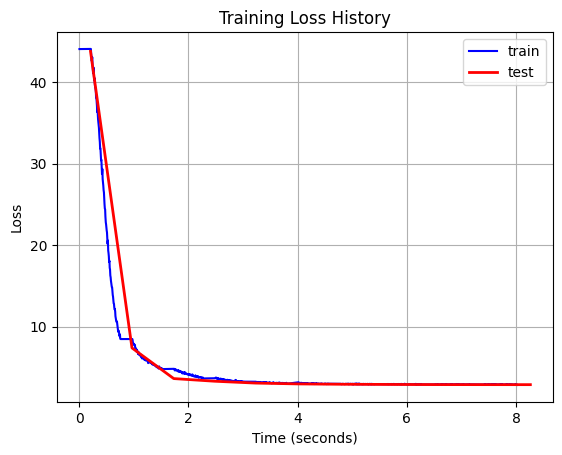

In [ ]:
# plot the loss history
plt.plot(model_results['train_time'], model_results['train_loss'], '-', label='train', color="blue")
plt.plot(model_results['val_time'], model_results['val_loss'], '-', label='test', lw=2, color="red")
plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title("Training Loss History")
plt.grid()  

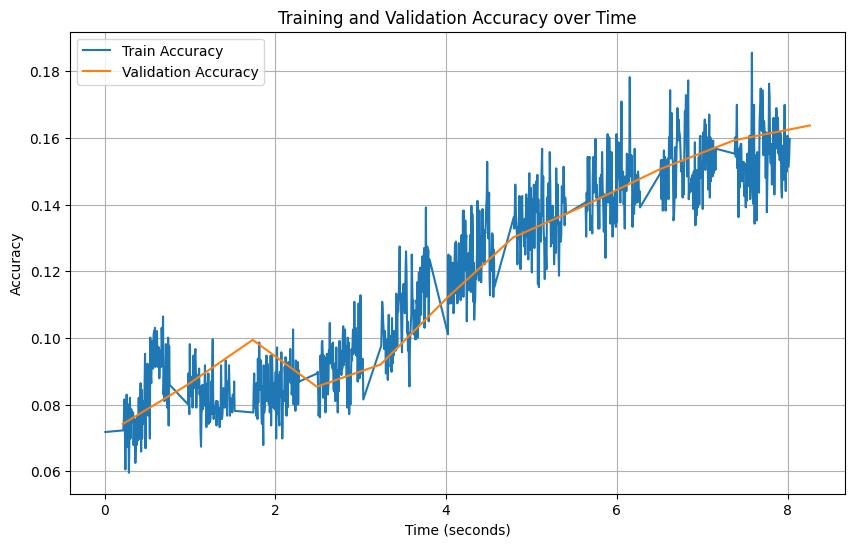

In [50]:
# Plot training and validation accuracy
plt.figure(figsize=(10,6))
plt.plot(model_results['train_time'], model_results['train_acc'], label='Train Accuracy')
plt.plot(model_results['val_time'], model_results['val_acc'], label='Validation Accuracy')
plt.xlabel('Time (seconds)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Time')
plt.legend()
plt.grid()
plt.show()
